# CS 7641 Assignment 3

## Unsupervised Learning and Dimensionality Reduction

Name: Tianyu Yang<br>
GTid: 903645962<br>
Date: 2020/9/20<br>

In this assignment, I will implement dimensionality reduction algorithms(ICA) with two datasets, NBA games and LOL games. These two datasets are what I used in the first assignment. I will build up the model for algorithms. Accuracy/Variance, reconstruction error will be plotted to evaluate the performance of dimensionality reduction. Besides, comparing with clustering algorithms, AIC/BIC, performance evaluation, per sample average log likelihood, variance explained figure will be plotted as referred.

## Import packages

In [1]:
!pip install cluster_func
# Importing useful packages
import os
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import FastICA
from cluster_func import kmeans
from cluster_func import em
import scipy

import warnings
warnings.filterwarnings('ignore')

You should consider upgrading via the 'c:\users\13102\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


## Loading and cleaning datasets

Data are downloaded from Kaggle:<br>
nba games https://www.kaggle.com/nathanlauga/nba-games<br>
lol games https://www.kaggle.com/datasnaek/league-of-legends?select=games.csv<br>

nba_games.csv : All games from 2004 season to last update with the date, teams and some details like number of points, etc.
lol_games.csv : This is a collection of over 50,000 ranked EUW games from the game League of Legends, as well as json files containing a way to convert between champion and summoner spell IDs and their names.

In [2]:
# Change the path into your current working directory
os.chdir(r"C:\Users\13102\Desktop\CS7641 Machine Learning Unsupervised Learning and Dimensionality Reduction")

nba_games = pd.read_csv('nba_games.csv')
lol_games = pd.read_csv('lol_games.csv')

### 1. NBA games data

We will calculate the different between home team and away team in five aspects, including FG_PCT(field goals percentage), FT_PCT(field throws percentage), FG3_PCT(three-point field goals percentage),AST(assists) and REB(rebounds). HOME_TEAM_WINS represents that if home team wins, the value is 1 and if home team loses, the value is 0.

In [3]:
data1 = nba_games[['GAME_DATE_EST','HOME_TEAM_WINS',]]
pd.options.mode.chained_assignment = None

# Select the data for 2019-2020 season from 2019-10-4 to 2020-3-1
start_date='2019-10-4'
end_date='2020-3-1'

data1['GAME_DATE_EST'] = pd.to_datetime(data1['GAME_DATE_EST'])  
mask = (data1['GAME_DATE_EST'] >= start_date) & (data1['GAME_DATE_EST'] <= end_date)
data1 = data1.loc[mask]

# Drop useless columns
data1 = data1.reset_index().drop(columns=['index', 'GAME_DATE_EST'])

cols1 = ['FG_PCT','FT_PCT','FG3_PCT','AST','REB']
for col in cols1:
    data1[col+'_diff'] = nba_games[col+'_home'].sub(nba_games[col+'_away'], axis = 0)

X1 = np.array(data1.values[:,1:-1],dtype='float')
Y1 = np.array(data1.values[:,0],dtype='float')
data1.describe(include='all')

,HOME_TEAM_WINS,FG_PCT_diff,FT_PCT_diff,FG3_PCT_diff,AST_diff,REB_diff
count,965.00000,965.000000,965.000000,965.000000,965.000000,965.000000
mean,0.54715,0.011031,0.001882,0.005033,1.174093,0.839378
std,0.49803,0.078655,0.146005,0.131647,6.439211,9.418250
min,0.00000,-0.208000,-0.571000,-0.427000,-22.000000,-39.000000
25%,0.00000,-0.043000,-0.092000,-0.086000,-3.000000,-5.000000
50%,1.00000,0.009000,0.000000,0.003000,1.000000,1.000000
75%,1.00000,0.068000,0.094000,0.098000,5.000000,7.000000
max,1.00000,0.258000,0.571000,0.458000,23.000000,31.000000


### 2. LOL games data

We will analyze the lol matches data There are two teams called 1 and 2. From six aspects including first blood, first tower, first inhibitor, first Baron, first Dragon, first RiftHerald to analyze the winner of each game.

In [4]:
data2 = lol_games[['winner','firstBlood','firstTower','firstInhibitor','firstBaron','firstDragon','firstRiftHerald']]
data2 = data2.astype(np.float64, copy=False)

# We only used 965 data for testing which is the same as data1
data2 = data2.head(965)
#X2 = data2.values[:,1:-1]
#Y2 = data2.values[:,0]

X2 = np.array(data1.values[:,1:-1],dtype='float')
Y2 = np.array(data1.values[:,0],dtype='float')
data2.describe(include='all')

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald
count,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000
mean,1.491192,1.469430,1.443523,1.304663,0.890155,1.441451,0.757513
std,0.500182,0.511637,0.544848,0.663535,0.832656,0.572486,0.821936
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


## ICA dimensionality reduction algorithm

### 1. NBA games datasets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X1,Y1, test_size = 0.2)

Starting ICA
Dimensionality reduction


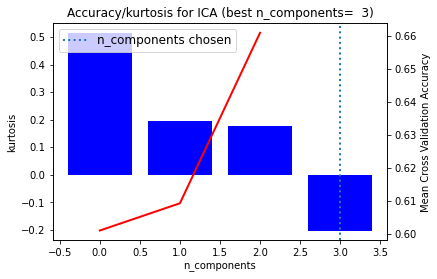

In [6]:
#Dimensionality reduction ICA
#kurtosis calculation

print("Starting ICA")
print("Dimensionality reduction")

def _calculate(X, ica_, n_components):
    
    components = ica_.components_
    ica_.components_ = components[:n_components]

    transformed = ica_.transform(X)
    ica_.components_ = components
 
    kurtosis = scipy.stats.kurtosis(transformed)

    return sorted(kurtosis, reverse = True)	



nn = MLPClassifier(hidden_layer_sizes=(30,), solver='adam', activation='logistic', learning_rate_init=0.05, 
                                max_iter=1000, random_state=100)
ica = FastICA()

pipe = Pipeline(steps=[('ica', ica), ('neural networks', nn)])

# Plot the ICA spectrum
ica.fit(X1)

fig, ax = plt.subplots()
ax.bar(np.arange(X1.shape[1]), _calculate(X1,ica, X1.shape[1]) , linewidth=2, color = 'blue')

plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('kurtosis')

#Checking the accuracy for taking all combination of components
n_components = range(1, X1.shape[1])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
gridSearch = GridSearchCV(pipe, dict(ica__n_components=n_components), cv = 3)
gridSearch.fit(X1, Y1)
results = gridSearch.cv_results_
ax1 = ax.twinx()

#Plotting the accuracies and best component
ax1.plot(results['mean_test_score'], linewidth = 2, color = 'red')
ax1.set_ylabel('Mean Cross Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)

plt.legend(prop=dict(size=12))
plt.title('Accuracy/kurtosis for ICA (best n_components=  %d)'%gridSearch.best_estimator_.named_steps['ica'].n_components )
plt.show()


#Reducing the dimensions with optimal number of components
ica_new = FastICA(n_components = gridSearch.best_estimator_.named_steps['ica'].n_components)
ica_new.fit(X_train)
X_train_transformed = ica_new.transform(X_train)
X_test_transformed = ica_new.transform(X_test)

Calculating Reconstruction Error


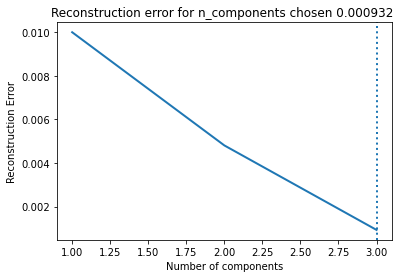

In [7]:
#Reconstruction Error

print("Calculating Reconstruction Error")


reconstruction_error = []
for comp in n_components:

	ica = FastICA(n_components = comp)
	X_transformed = ica.fit_transform(X_train)
	X_projected = ica.inverse_transform(X_transformed)
	reconstruction_error.append(((X_train - X_projected) ** 2).mean())

	if(comp == gridSearch.best_estimator_.named_steps['ica'].n_components):
		chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
ax2.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen %f '%chosen_error)
plt.show()

Clustering ICA
Expected Maximization
Training accuracy for Expected Maximization for K = 2:  48.056994818652846
Testing accuracy for Expected Maximization for K = 2:  48.704663212435236
KMeans
Training accuracy for KMeans for K = 2:  42.74611398963731
Testing accuracy for KMeans for K = 2:  46.1139896373057


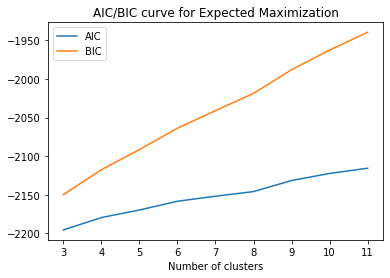

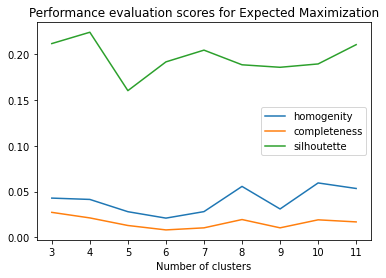

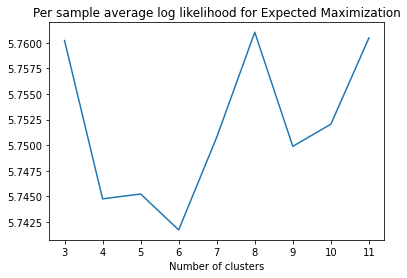

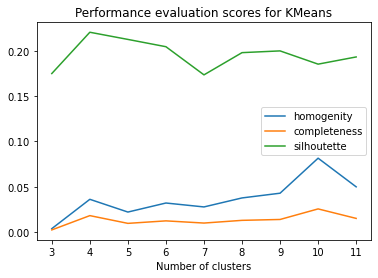

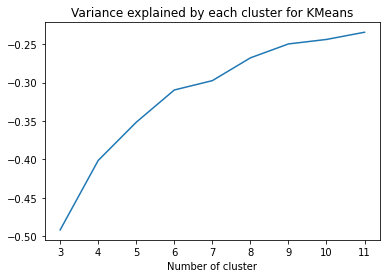

In [8]:
#Reducing the dimensions with optimal number of components
ica_new = FastICA(n_components = gridSearch.best_estimator_.named_steps['ica'].n_components)
ica_new.fit(X1)
X_transformed_f = ica_new.transform(X1)


#Clustering after dimensionality reduction
print("Clustering ICA")


means_init = np.array([X_transformed_f[Y1 == i].mean(axis=0) for i in range(2)])

#clustering experiments
print("Expected Maximization")
component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log = em(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 2, toshow =0)

print("KMeans")
component_list, array_homo_2, array_comp_2, array_sil_2, array_var = kmeans(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 2, toshow = 0)



In [9]:
#Writing data to file
component_list = np.array(component_list).reshape(-1,1)
array_aic = np.array(array_aic).reshape(-1,1)
array_bic = np.array(array_bic).reshape(-1,1)
array_homo_1 = np.array(array_homo_1).reshape(-1,1)
array_comp_1 = np.array(array_comp_1).reshape(-1,1)
array_sil_1 = np.array(array_sil_1).reshape(-1,1)
array_avg_log = np.array(array_avg_log).reshape(-1,1)
array_homo_2 = np.array(array_homo_2).reshape(-1,1)
array_comp_2 = np.array(array_comp_2).reshape(-1,1)
array_sil_2 = np.array(array_sil_2).reshape(-1,1)
array_var = np.array(array_var).reshape(-1,1)

reconstruction_error = np.array(reconstruction_error).reshape(-1,1)

data_em_ica_cancer = np.concatenate((component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log), axis =1)

data_km_ica_cancer = np.concatenate((component_list, array_homo_2, array_sil_2, array_var), axis =1)

reconstruction_error_ica_cancer = np.concatenate((np.arange(1,X1.shape[1]).reshape(-1,1), reconstruction_error), axis = 1)

file = './outputs/data_em_ica_nba.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(data_em_ica_cancer)

file = './outputs/data_km_ica_nba.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(data_km_ica_cancer)

file = './outputs/reconstruction_error_ica_nba.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(reconstruction_error_ica_cancer)

### 2. LOL games datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X2,Y2, test_size = 0.2)

Starting ICA
Dimensionality reduction


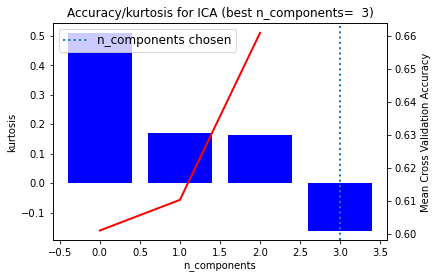

In [11]:
#Dimensionality reduction ICA
#kurtosis calculation

print("Starting ICA")
print("Dimensionality reduction")

def _calculate(X, ica_, n_components):
    
    components = ica_.components_
    ica_.components_ = components[:n_components]

    transformed = ica_.transform(X)
    ica_.components_ = components
 
    kurtosis = scipy.stats.kurtosis(transformed)

    return sorted(kurtosis, reverse = True)	



nn = MLPClassifier(hidden_layer_sizes=(30,), solver='adam', activation='logistic', learning_rate_init=0.05, 
                                max_iter=1000, random_state=100)
ica = FastICA()

pipe = Pipeline(steps=[('ica', ica), ('neural networks', nn)])

# Plot the ICA spectrum
ica.fit(X2)

fig, ax = plt.subplots()
ax.bar(np.arange(X2.shape[1]), _calculate(X2,ica, X2.shape[1]) , linewidth=2, color = 'blue')

plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('kurtosis')

#Checking the accuracy for taking all combination of components
n_components = range(1, X2.shape[1])
gridSearch = GridSearchCV(pipe, dict(ica__n_components=n_components), cv = 3)
gridSearch.fit(X2, Y2)
results = gridSearch.cv_results_
ax1 = ax.twinx()

#Plotting the accuracies and best component
ax1.plot(results['mean_test_score'], linewidth = 2, color = 'red')
ax1.set_ylabel('Mean Cross Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)

plt.legend(prop=dict(size=12))
plt.title('Accuracy/kurtosis for ICA (best n_components=  %d)'%gridSearch.best_estimator_.named_steps['ica'].n_components )
plt.show()


#Reducing the dimensions with optimal number of components
ica_new = FastICA(n_components = gridSearch.best_estimator_.named_steps['ica'].n_components)
ica_new.fit(X_train)
X_train_transformed = ica_new.transform(X_train)
X_test_transformed = ica_new.transform(X_test)

Calculating Reconstruction Error


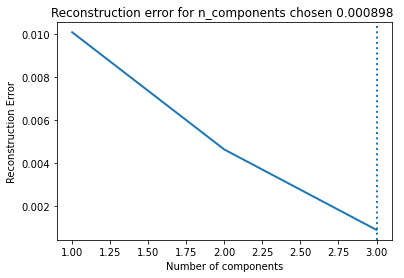

In [12]:
#Reconstruction Error

print("Calculating Reconstruction Error")


reconstruction_error = []
for comp in n_components:

	ica = FastICA(n_components = comp)
	X_transformed = ica.fit_transform(X_train)
	X_projected = ica.inverse_transform(X_transformed)
	reconstruction_error.append(((X_train - X_projected) ** 2).mean())

	if(comp == gridSearch.best_estimator_.named_steps['ica'].n_components):
		chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
ax2.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen %f '%chosen_error)
plt.show()

Clustering ICA
Expected Maximization
Training accuracy for Expected Maximization for K = 2:  32.512953367875646
Testing accuracy for Expected Maximization for K = 2:  31.088082901554404
KMeans
Training accuracy for KMeans for K = 2:  33.80829015544041
Testing accuracy for KMeans for K = 2:  33.160621761658035


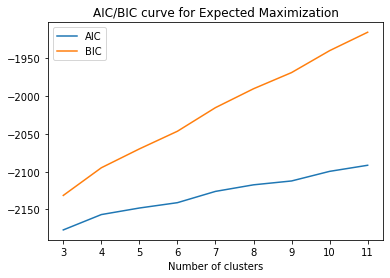

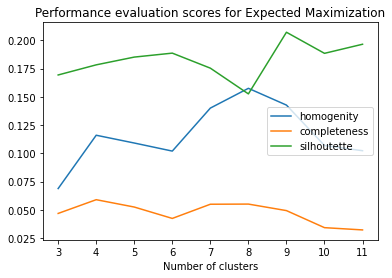

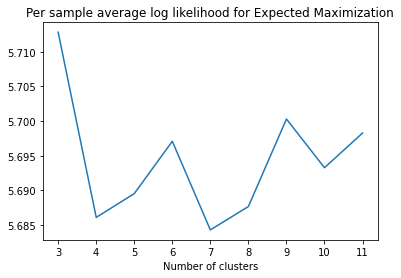

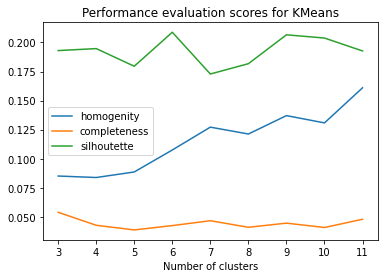

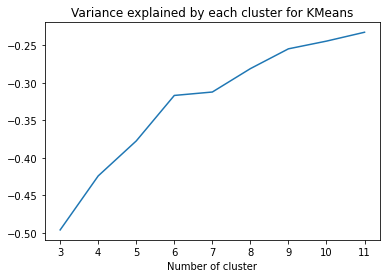

In [13]:
#Reducing the dimensions with optimal number of components
ica_new = FastICA(n_components = gridSearch.best_estimator_.named_steps['ica'].n_components)
ica_new.fit(X2)
X_transformed_f = ica_new.transform(X2)


#Clustering after dimensionality reduction
print("Clustering ICA")


means_init = np.array([X_transformed_f[Y2 == i].mean(axis=0) for i in range(2)])

#clustering experiments
print("Expected Maximization")
component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log = em(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 2, toshow =0)

print("KMeans")
component_list, array_homo_2, array_comp_2, array_sil_2, array_var = kmeans(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 2, toshow = 0)



In [14]:
#Writing data to file
component_list = np.array(component_list).reshape(-1,1)
array_aic = np.array(array_aic).reshape(-1,1)
array_bic = np.array(array_bic).reshape(-1,1)
array_homo_1 = np.array(array_homo_1).reshape(-1,1)
array_comp_1 = np.array(array_comp_1).reshape(-1,1)
array_sil_1 = np.array(array_sil_1).reshape(-1,1)
array_avg_log = np.array(array_avg_log).reshape(-1,1)
array_homo_2 = np.array(array_homo_2).reshape(-1,1)
array_comp_2 = np.array(array_comp_2).reshape(-1,1)
array_sil_2 = np.array(array_sil_2).reshape(-1,1)
array_var = np.array(array_var).reshape(-1,1)

reconstruction_error = np.array(reconstruction_error).reshape(-1,1)

data_em_ica_cancer = np.concatenate((component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log), axis =1)

data_km_ica_cancer = np.concatenate((component_list, array_homo_2, array_sil_2, array_var), axis =1)

reconstruction_error_ica_cancer = np.concatenate((np.arange(1,X2.shape[1]).reshape(-1,1), reconstruction_error), axis = 1)

file = './outputs/data_em_ica_lol.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(data_em_ica_cancer)

file = './outputs/data_km_ica_lol.csv'
with open(file, 'w', newline = '') as output:
    writer = csv.writer(output, delimiter=',')
    writer.writerows(data_km_ica_cancer)

file = './outputs/reconstruction_error_ica_lol.csv'
with open(file, 'w', newline = '') as output:
    writer = csv.writer(output, delimiter=',')
    writer.writerows(reconstruction_error_ica_cancer)